In [1]:
import os, sys
sys.path.append('/Users/premyslciompa/Documents/Projekty/SciApp/python')

from funkce import *
from zobrazovaci_funkce import *
import pandas
import pymongo

client = pymongo.MongoClient()
db = client.MyDb
dataCollection = db.Data

import bson
import pickle
import time

from concurrent.futures import ThreadPoolExecutor
pool = ThreadPoolExecutor()


%matplotlib inline

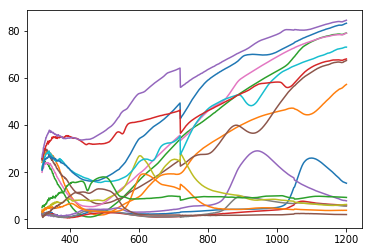

In [2]:
pathToData = 'file://localhost' + os.getcwd() + '/data/Grating_520nm_840nm_wo_specular.csv'

#Napred je reflexe, potom transmise, napred S, potom P
#Uhly 6, 15, 30, 45
n_rows = 641
loaded_data = pandas.read_csv(pathToData, header=1, nrows=n_rows)

for x in range(18):
    if x > 1:
        plt.plot(loaded_data.iloc[:,2*x],loaded_data.iloc[:,2*x+1])

plt.show()

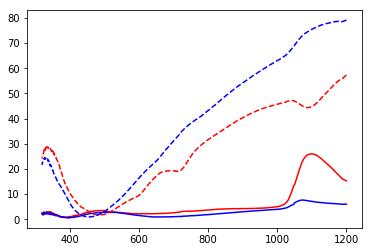

In [3]:
points = loaded_data.iloc[:,0]
deg6_ref_spec_s = loaded_data.iloc[:,5]
deg6_ref_spec_p = loaded_data.iloc[:,11]
deg6_trans_spec_s = loaded_data.iloc[:,7]
deg6_trans_spec_p = loaded_data.iloc[:,9]

plt.plot(points,deg6_ref_spec_s, 'r-')
plt.plot(points,deg6_ref_spec_p, 'b-')
plt.plot(points,deg6_trans_spec_s, 'r--')
plt.plot(points,deg6_trans_spec_p, 'b--')
plt.show()

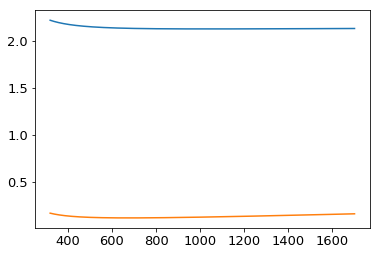

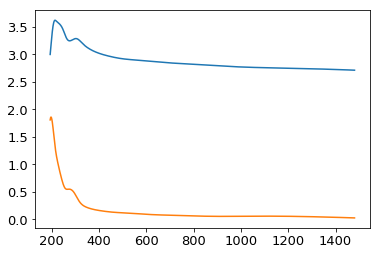

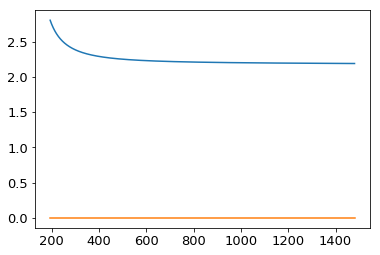

In [38]:
path_coating_fun = 'file://localhost' + os.getcwd() + '/data/CCL_grid_coating.csv'
path_lak_fun = 'file://localhost' + os.getcwd() + '/data/CCL_grid_lak.csv'
path_substrate_fun = 'file://localhost' + os.getcwd() + '/data/CCL_grid_substrate.csv'

n_rows = 1000 #761

wv_coating = pandas.read_csv(path_coating_fun,header=127,sep='\t',nrows=n_rows)
wv_lak = pandas.read_csv(path_lak_fun,header=0,sep='\t',nrows=n_rows)
wv_substrate = pandas.read_csv(path_substrate_fun,header=0,sep='\t',nrows=n_rows)

plt.plot(wv_coating.iloc[:,0]/10, wv_coating.iloc[:,1],wv_coating.iloc[:,0]/10, wv_coating.iloc[:,2])
plt.show()

plt.plot(wv_lak.iloc[:,0]/10, wv_lak.iloc[:,1],wv_lak.iloc[:,0]/10, wv_lak.iloc[:,2])
plt.show()

plt.plot(wv_substrate.iloc[:,0]/10, wv_substrate.iloc[:,1],wv_substrate.iloc[:,0]/10, wv_substrate.iloc[:,2])
plt.show()

wv_array = wv_coating.iloc[:,0].values / 10

wv_coating = wv_coating.iloc[:,1].values - 1j * wv_coating.iloc[:,2].values
wv_lak = wv_lak.iloc[:,1].values - 1j * wv_lak.iloc[:,2].values
wv_substrate = wv_substrate.iloc[:,1].values - 1j * wv_substrate.iloc[:,2].values

every_nth = 8
wv_array = wv_array[1::every_nth]
wv_coating = wv_coating[1::every_nth]
wv_lak = wv_lak[1::every_nth]
wv_substrate = wv_substrate[1::every_nth]

In [41]:
def show_measurement_gratings(values, options):
    
    font = {'size': 13, 'weight': 'normal'}

    matplotlib.rc('font', **font)
    
    values = np.real(values)
    points2 = np.linspace(options['divisions_start'], options['divisions_end'], options['divisions'])
    
    fig2 = plt.figure(14, figsize=(6.75, 5.55))
    plt.title("Specular transmission")
    plt.plot(points2, values[:, 2, 0], 'r--', label='Ts - model')
    plt.plot(points2, values[:, 3, 0], 'b--', label='Tp - model')
    plt.plot(points, deg6_trans_spec_s/100, 'r-', label='Ts - measurement')
    plt.plot(points, deg6_trans_spec_p/100, 'b-', label='Ts - measurement')
    plt.xlabel(options['dependence']['label'])
    max = np.array([values[:, 2, 0], values[:, 3, 0]]).max()
    plt.axis([options['divisions_start'], options['divisions_end'], 0, 1.4 * max])
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    fig3 = plt.figure(15, figsize=(6.75, 5.55))
    plt.title("Specular reflection")
    plt.plot(points2, values[:, 0, 0], 'r--', label='Rs - model')
    plt.plot(points2, values[:, 1, 0], 'b--', label='Rp - model')
    plt.plot(points, deg6_ref_spec_s/100, 'r-', label='Rs - measurement')
    plt.plot(points, deg6_ref_spec_p/100, 'b-', label='Rp - measurement')
   # max = np.array([values[:, 0, 0], values[:, 1, 0]]).max()
    plt.axis([options['divisions_start'], options['divisions_end'], 0, 0.4])
    plt.xlabel(options['dependence']['label'])
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    fig3 = plt.figure(14, figsize=(6.75, 5.55))
    plt.title("Specular transmission")
    plt.plot(points2, values[:, 2, 0], 'r--', label='Ts - model')
    plt.plot(points2, values[:, 3, 0], 'b--', label='Tp - model')
    plt.xlabel(options['dependence']['label'])
    max = np.array([values[:, 2, 0], values[:, 3, 0]]).max()
    plt.axis([options['divisions_start'], options['divisions_end'], 0, 1.4 * max])
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [17]:
%%time

def general_func_temp(wvs, options_input, angle):
    
    def get_structure_and_options(index):
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 15,
            'n_select': 4,
            'wavelength': wvs[index],
            'angle': angle,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        width_lak = 450
        width_grating = 480

        perm_coating = 2.4
        perm_lak = np.real(wv_coating[index])
        perm_substrate = wv_substrate[index]

        structure = {
            'bound_selectors': [
                # ['data', 0, 'permittivity', 4],

                # ['data', 0, 'permittivity', 8],
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': np.sqrt(perm_substrate),
            'period': 1085,
            'data': [
                {'width': width_lak, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_lak, 0, 0, 0, perm_lak, 0, 0, 0, perm_lak], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': width_grating-width_lak, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0, perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': width_lak, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [perm_lak, 0, 0, 0, perm_lak, 0, 0, 0,perm_lak], 'start': fill_grating, 'stop': 1},
                ]},
            ]}
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]

options_input = {
    'divisions': wv_array.size,
    'divisions_start': wv_array[0],
    'divisions_end': wv_array[-1],
    'dependence': {
        'name': 'wavelength',  ##angle // wavelength // structure
        'label': 'Wavelength [nm]'
    }
}

values = general_func_temp(wv_array, options_input, 6)

CPU times: user 36.6 s, sys: 505 ms, total: 37.1 s
Wall time: 19 s


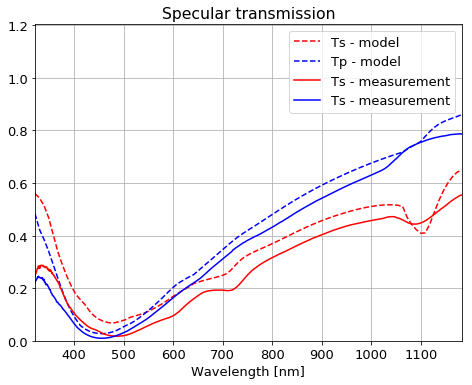

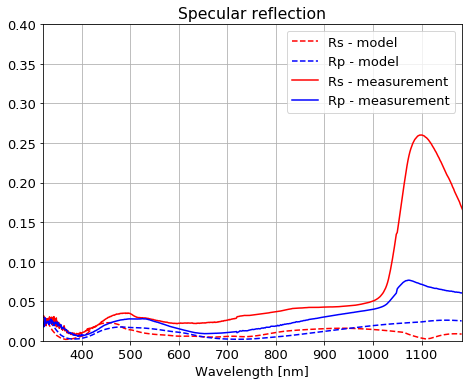

In [20]:
show_measurement_gratings(values, options_input)

In [24]:
%%time

def general_func_temp(wvs, options_input, angle):
    
    def get_structure_and_options(index):
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 10,
            'n_select': 3,
            'wavelength': wvs[index],
            'angle': angle,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        width_lak = 450
        width_grating = 470

        perm_coating = 2.4
        perm_lak = np.real(wv_coating[index])
        perm_substrate = wv_substrate[index]

        structure = {
            'bound_selectors': [
                # ['data', 0, 'permittivity', 4],

                # ['data', 0, 'permittivity', 8],
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1100,
            'data': [
                {'width': width_lak, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_lak, 0, 0, 0, perm_lak, 0, 0, 0, perm_lak], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': width_grating-width_lak, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0, perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': width_lak, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [perm_lak, 0, 0, 0, perm_lak, 0, 0, 0,perm_lak], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': 50000, 'periodic': False, 'coherent': True,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]},
            ]}
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]

options_input = {
    'divisions': wv_array.size,
    'divisions_start': wv_array[0],
    'divisions_end': wv_array[-1],
    'dependence': {
        'name': 'wavelength',  ##angle // wavelength // structure
        'label': 'Wavelength [nm]'
    }
}

values = general_func_temp(wv_array, options_input, 7)

CPU times: user 21.3 s, sys: 131 ms, total: 21.4 s
Wall time: 10.9 s


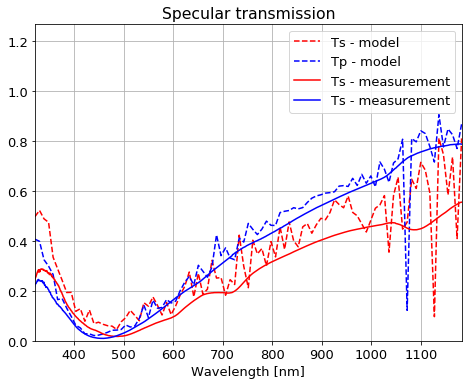

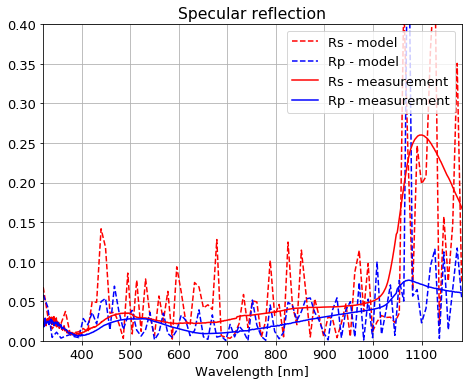

In [25]:
show_measurement_gratings(values, options_input)

In [39]:
%%time

def general_func_temp(wvs, options_input, angle):
    
    def get_structure_and_options(index):
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 10,
            'n_select': 3,
            'wavelength': wvs[index],
            'angle': angle,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        width_lak = 450
        width_grating = 470

        perm_coating = 2.4
        perm_lak = np.real(wv_coating[index])
        perm_substrate = wv_substrate[index]

        structure = {
            'bound_selectors': [
                # ['data', 0, 'permittivity', 4],

                # ['data', 0, 'permittivity', 8],
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1100,
            'data': [
                {'width': width_lak, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_lak, 0, 0, 0, perm_lak, 0, 0, 0, perm_lak], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': width_grating-width_lak, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0, perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [1, 0, 0, 0, 1, 0, 0, 0, 1], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': width_lak, 'periodic': True, 'coherent': True, 'materials': [
                    {'permittivity': [perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate], 'start': 0,
                     'stop': fill_grating},
                    {'permittivity': [perm_lak, 0, 0, 0, perm_lak, 0, 0, 0,perm_lak], 'start': fill_grating, 'stop': 1},
                ]},
                {'width': 50000, 'periodic': False, 'coherent': False,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]},
            ]}
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]

options_input = {
    'divisions': wv_array.size,
    'divisions_start': wv_array[0],
    'divisions_end': wv_array[-1],
    'dependence': {
        'name': 'wavelength',  ##angle // wavelength // structure
        'label': 'Wavelength [nm]'
    }
}

values = general_func_temp(wv_array, options_input, 7)

CPU times: user 36.3 s, sys: 563 ms, total: 36.8 s
Wall time: 18.6 s


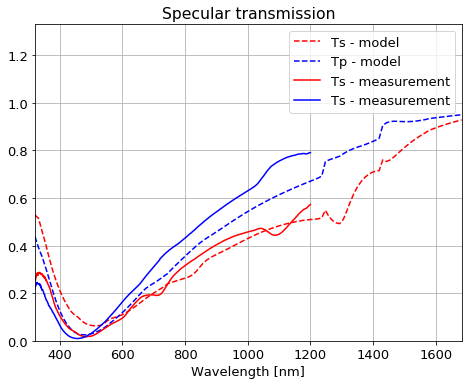

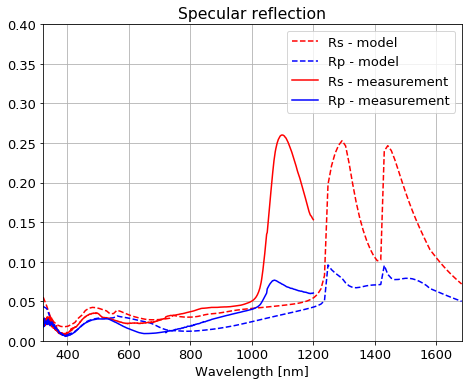

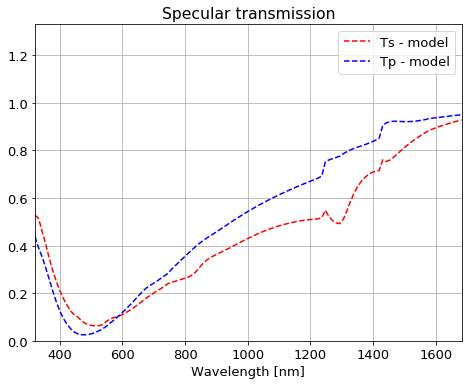

In [42]:
show_measurement_gratings(values, options_input)